# SupplyzPro: Technical Assessment

# 1. Assessment Introduction

## Goal




In this assessment, your objective is to explore and forecast the industrial production of electric and gas utilities in the United States from 1939 to 2019. The data, sourced from the Federal Reserve Economic Data (FRED) database, provides monthly production output, allowing us to analyze long-term trends, seasonal patterns, and forecast future values.

Data Source: Industrial Production: Electric and Gas Utilities 
Link: https://fred.stlouisfed.org/series/IPG2211A2N




## Recommendations


As you proceed, keep in mind the following evaluation criteria:

- Code Modularity: Structure your code into clear, reusable functions where possible.
- Code Quality: Ensure readability, use meaningful variable names, and document your steps.
- Explain Your Reasoning: Include comments and markdown explanations for each decision made, describing your approach and any assumptions.

**IMPORTANT: We highly recommend structuring the code in separate scripts instead of using a single notebook for everything.!** 


# Code 

## 1. Data Exploration


In this section we recommend you to:
- Visualizing the data to get an overview of its patterns and structure.
- Preparing the data as needed to ensure it’s ready for analysis.
- Identifying any trends or recurring patterns that may influence the approach to modeling.


### Data Exploration

#### Importing Libraries

In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pylab import rcParams
import seaborn as sns
sns.set()
import plotly.express as px
from statsmodels.graphics.tsaplots import month_plot
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from tqdm import tqdm
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from chronos import ChronosPipeline
import torch


rcParams['figure.figsize'] = 15, 4


In [4]:
# Load the df
df = pd.read_csv('IPG2211A2N.csv')

# Display the first few rows of the df 
df.head()

,DATE,IPG2211A2N
0,1939-01-01,3.3336
1,1939-02-01,3.3591
2,1939-03-01,3.4354
3,1939-04-01,3.4608
4,1939-05-01,3.4608


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        1030 non-null   object 
 1   IPG2211A2N  1030 non-null   float64
dtypes: float64(1), object(1)
memory usage: 16.2+ KB


In [6]:
df.shape

(1030, 2)

### Data preprocessing

In [7]:
df.rename(columns = {'IPG2211A2N':'value','DATE':'date'}, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1030 non-null   object 
 1   value   1030 non-null   float64
dtypes: float64(1), object(1)
memory usage: 16.2+ KB


In [8]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df.set_index('date', inplace=True)
df = df.resample('M').mean()
df['month_name'] = df.index.strftime('%b')

df.head()

,value,year,month,month_name
date,,,,
1939-01-31,3.3336,1939.0,1.0,Jan
1939-02-28,3.3591,1939.0,2.0,Feb
1939-03-31,3.4354,1939.0,3.0,Mar
1939-04-30,3.4608,1939.0,4.0,Apr
1939-05-31,3.4608,1939.0,5.0,May


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1030 entries, 1939-01-31 to 2024-10-31
Freq: ME
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   value       1030 non-null   float64
 1   year        1030 non-null   float64
 2   month       1030 non-null   float64
 3   month_name  1030 non-null   object 
dtypes: float64(3), object(1)
memory usage: 40.2+ KB


From the previous command, we can conclude that our dataset is simple: 
- There are no NaN values.  
- The dataset contains only two columns.  
- It has a small number of rows (1030). 

### Data visualization

Text(0.5, 1.0, 'Electronic production amount from 1939 to 2024')

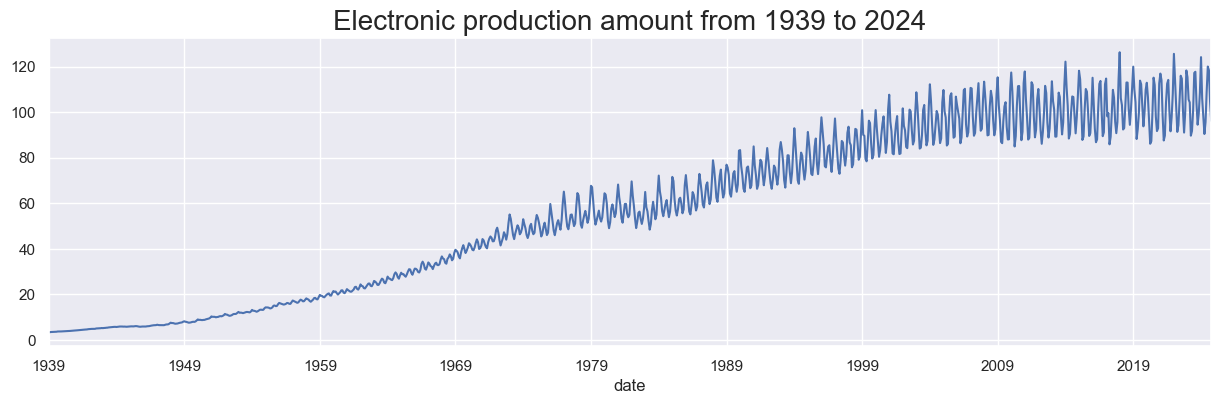

In [10]:
fig = df['value'].plot()
fig.set_title("Electronic production amount from 1939 to 2024",fontsize=20)

In [43]:
df_from_1942 = df[df['year'] >= 1942]
fig = px.line_polar(df_from_1942, r="value", theta="month_name", color="year", line_close=True,
                    color_discrete_sequence=px.colors.qualitative.Plotly)
fig.update_layout(title="Polar Line Plot from 1942")
fig.show()

In [44]:
df_past_14_year = df[df['year'] >= 2010]
fig = px.line_polar(df_past_14_year, r="value", theta="month_name", color="year", line_close=True,
                    color_discrete_sequence=px.colors.qualitative.Plotly)
fig.update_layout(title="Polar Line Plot from the Past 14 Years")
fig.show()

In [ ]:
fig = px.box(df, x="month_name", y="value")
fig.update_layout(title="Box Plot of Electric and Gas Utilities by Month")
fig.show()

skewness of distribution -0.01877242192636524


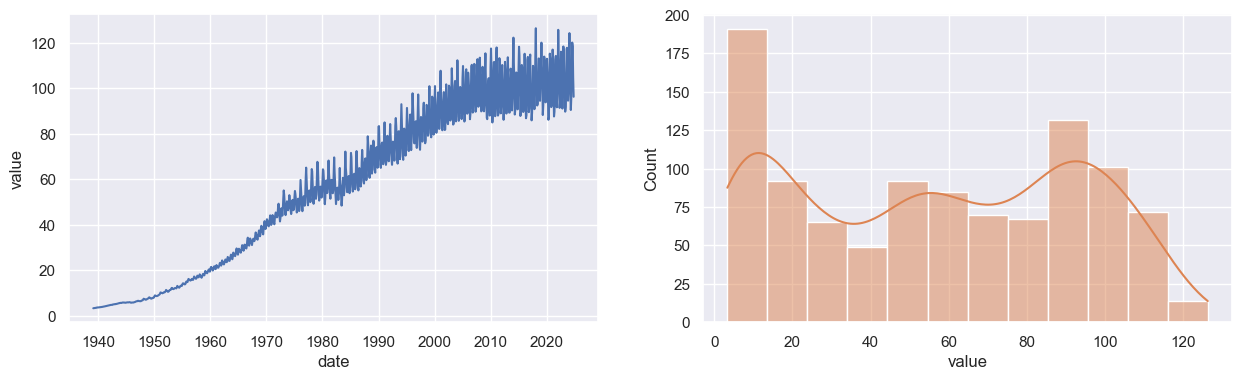

In [51]:
def hist_plots(ts):
    fig, ax = plt.subplots(1, 2, figsize=(15, 4))
    sns.histplot()
    sns.lineplot(data=ts, ax=ax[0])
    sns.histplot(data=ts, ax=ax[1], kde=True)
    print("skewness of distribution", ts.skew())

hist_plots(df['value'])

<Axes: xlabel='date'>

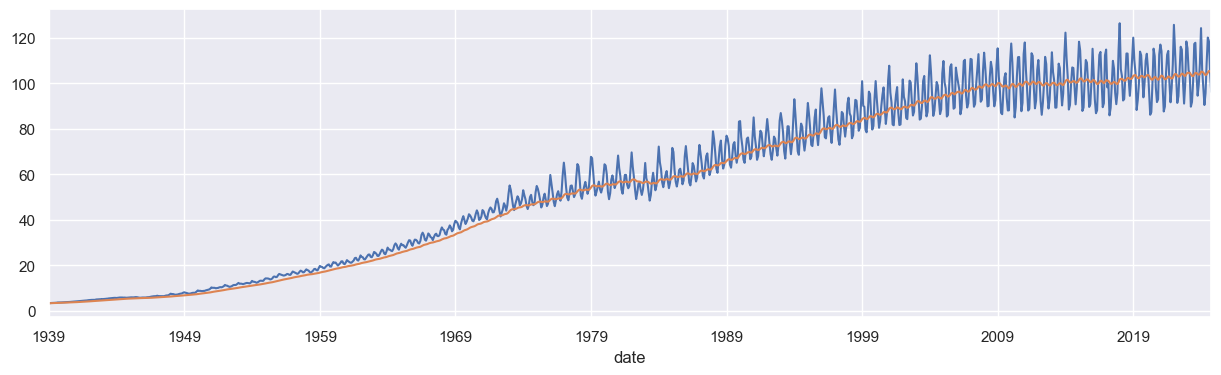

In [16]:
df['value'].plot()
df['value'].ewm(alpha=0.05).mean().plot()

#### Time Series Decomposition with Additive Model

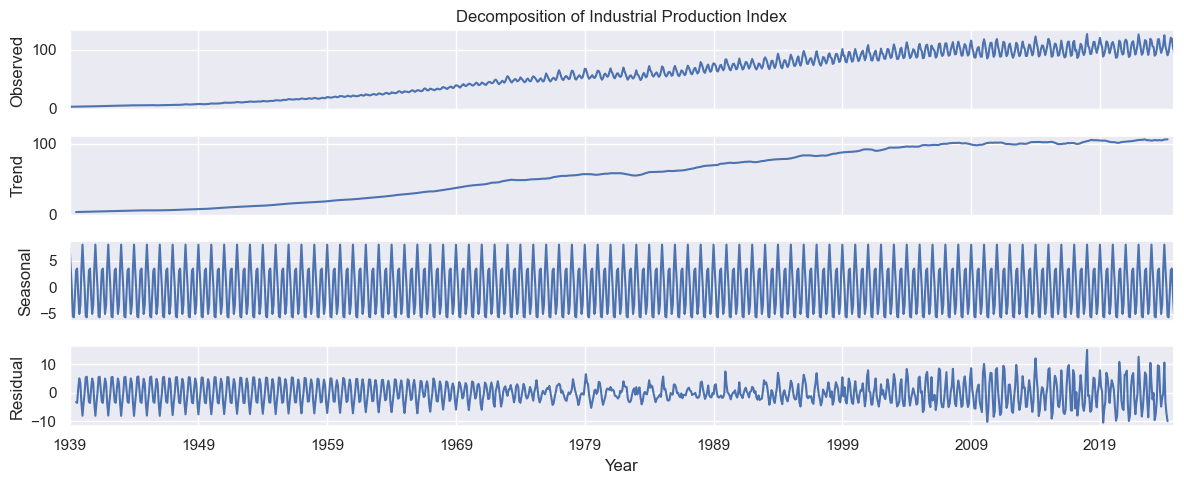

In [17]:
# Decompose the time series using an additive model
decomposition = seasonal_decompose(df['value'], model='additive', period=12)

# Plot the decomposed components: Observed, Trend, Seasonal, and Residual
fig, axes = plt.subplots(4, 1, figsize=(12, 5), sharex=True)

# Plot the observed component
decomposition.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
axes[0].set_title('Decomposition of Industrial Production Index')

# Plot the trend component
decomposition.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')

# Plot the seasonal component
decomposition.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')

# Plot the residual component
decomposition.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Year')

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

#### White noise distribution

count    1018.000000
mean       -0.015123
std         3.906625
min       -10.487111
25%        -3.143169
50%         0.062507
75%         2.585604
max        15.052516
Name: resid, dtype: float64


Text(0.5, 1.0, 'Mean of residual over time')

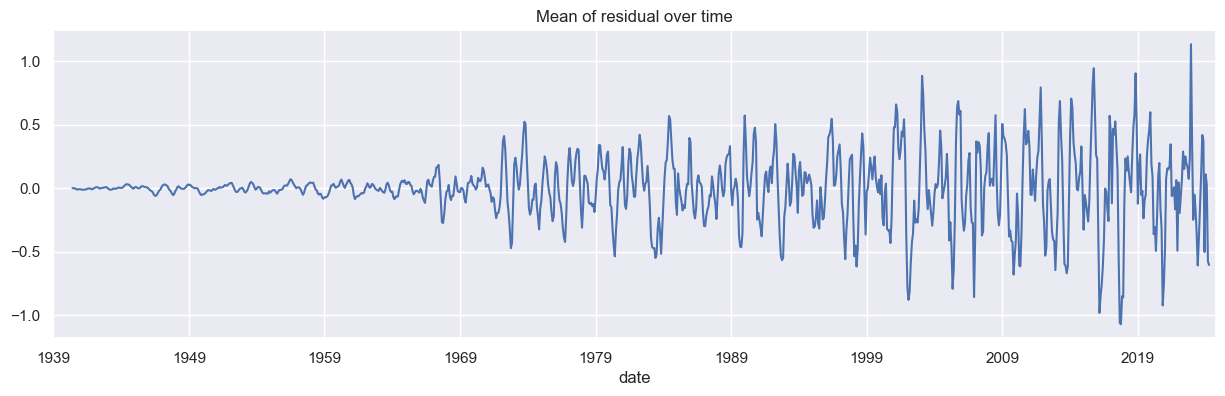

In [18]:
mean = decomposition.resid.rolling(12).mean()
print(decomposition.resid.describe())
mean.plot()
plt.title("Mean of residual over time")


<Axes: >

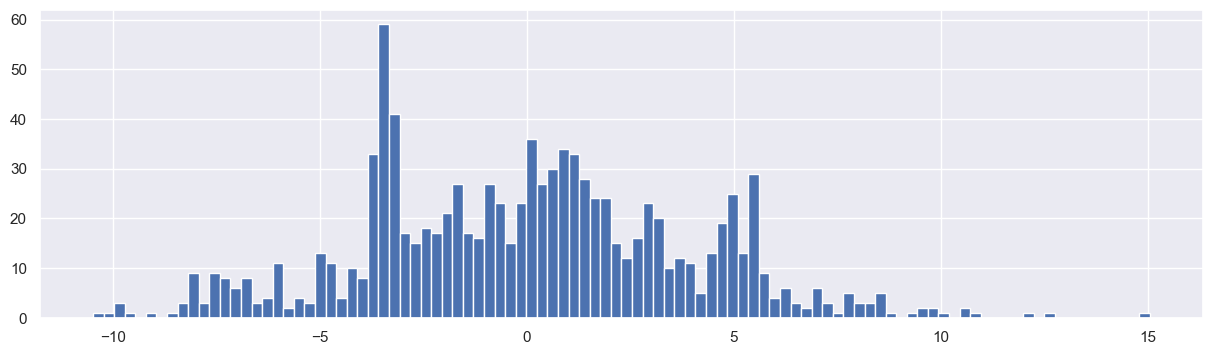

In [19]:
decomposition.resid.hist(bins=100)

#### Checking Stationarity of the Time Series
To verify the stationarity of time series data,
one of the most common way is to apply Augmented Dickey Fuller Test (ADF Test). Simply talking the concept, the test is to prove the existence of unit root. The time series data is stationary if it is not exist and null hypothesis will be rejected.


In [20]:
adf_result = adfuller(df['value'])
print('ADF Statistic: %f' % adf_result[0])
print('MacKinnon approximate p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.714416
MacKinnon approximate p-value: 0.842980
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


Here we have `p-value: 0.84` then our serie not stasionnaire 

Ici on va appliquez des différenciations (d) jusqu'à obtenir une stationnarité

#### Différenciation pour stationnarité

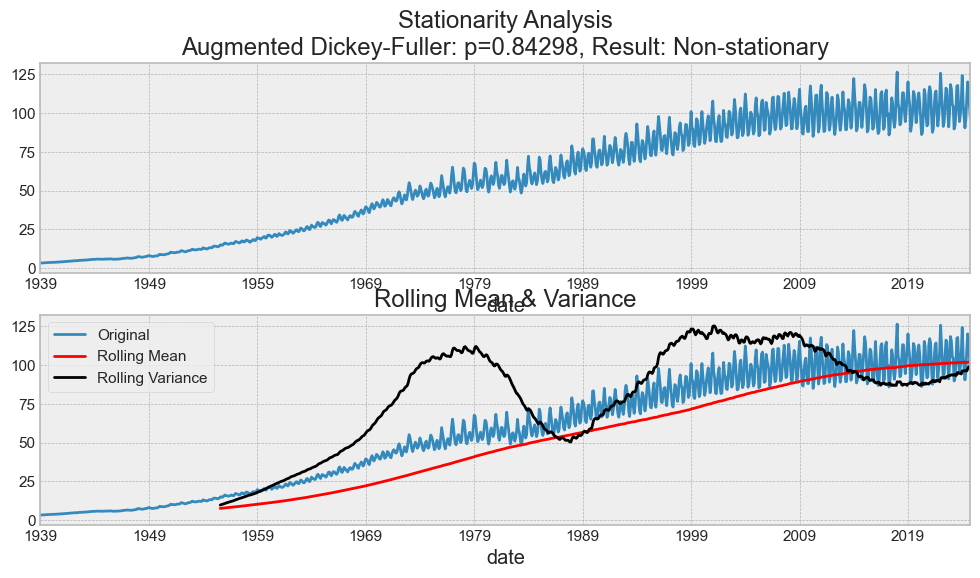

In [21]:
# Function to perform ADF Test and visualize stationarity
def adf_test_and_tsplot(y, figsize=(12, 6), style='bmh', rolling_window=200):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):  # Use specified style for plots
        # Define figure layout
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)  # Time series plot
        rol_ax = plt.subplot2grid(layout, (1, 0), colspan=2)  # Rolling stats plot
        
        # Plot original series
        y.plot(ax=ts_ax)
        
        # Perform ADF Test and display result
        p_value = adfuller(y)[1]
        hypothesis_result = "Stationary" if p_value <= 0.05 else "Non-stationary"
        ts_ax.set_title(
            'Stationarity Analysis\nAugmented Dickey-Fuller: p={0:.5f}, Result: {1}'.format(p_value, hypothesis_result))
        
        # Plot rolling mean and variance
        rolmean = y.rolling(window=rolling_window).mean()
        rolvar = y.rolling(window=rolling_window).var()
        y.plot(label='Original', ax=rol_ax)
        rolmean.plot(color='red', label='Rolling Mean', ax=rol_ax)
        rolvar.plot(color='black', label='Rolling Variance', ax=rol_ax)
        rol_ax.legend(loc='best')
        rol_ax.set_title('Rolling Mean & Variance')

# Apply the function to the 'value' column of the dataset
adf_test_and_tsplot(df['value'])

#### Visualisation ACF et PACF

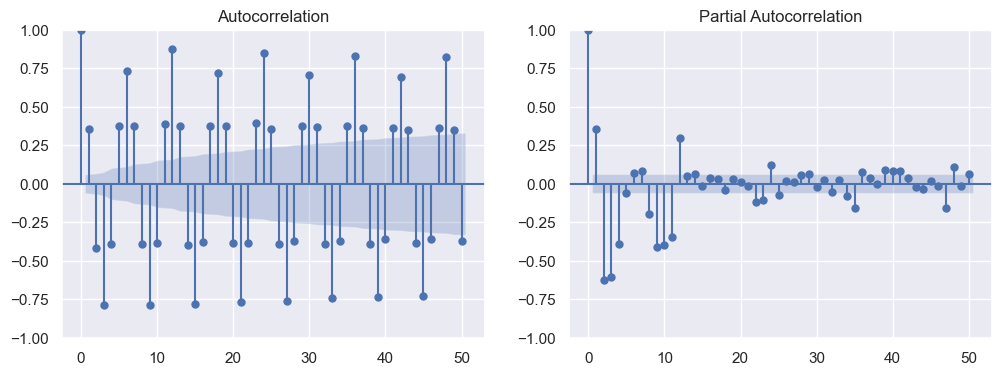

In [22]:
df['Diff'] = df['value'].diff()
df['Diff'].dropna(inplace=True)
plt.figure(figsize=(12, 4))
plot_acf(df['Diff'].dropna(), lags=50, ax=plt.subplot(121))
plot_pacf(df['Diff'].dropna(), lags=50, ax=plt.subplot(122))
plt.show()


Since the stationarity is not achieved, we will apply a logarithmic transformation to the data to see if it helps stabilize the mean and variance.

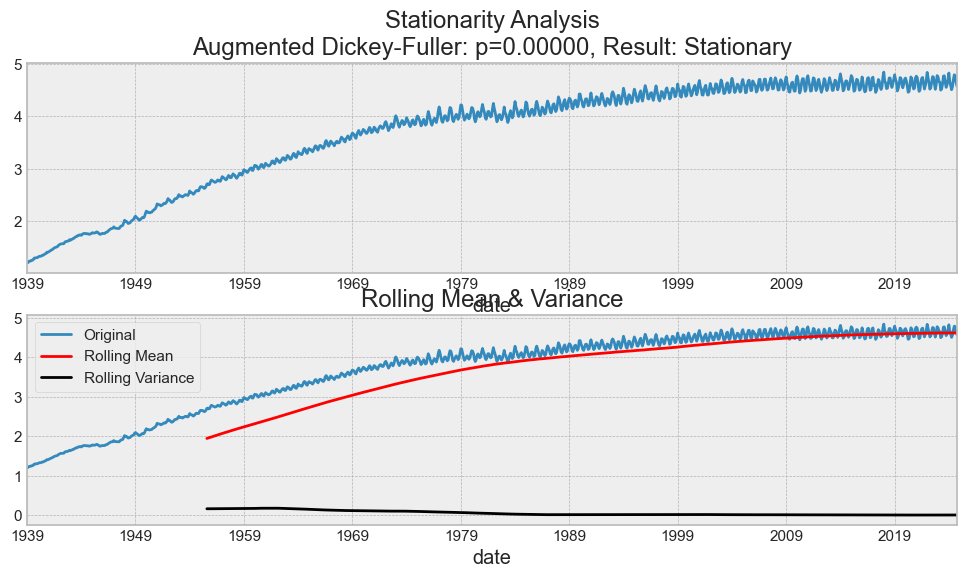

In [23]:
ts_transform = np.log(df['value'])
adf_test_and_tsplot(ts_transform)

After applying the logarithmic transformation, the time series data is now stationary.

## 2. Model Building

In this section, focus on:

- Selecting model parameters based on initial observations.
- Building appropriate models that align with the data characteristics.
- Refining the model through adjustments to enhance its ability to capture essential patterns.


We will compare the following models:

- **ARIMA**: A classical model for stationary time series.
- **SARIMA**: An enhanced version of ARIMA for handling seasonal components.
- **STS Simple exponential smoothing**: Captures exponential trends and seasonality.
- **Prophet (by Meta)**: Robust for time series with irregularities or holidays.
- **Holt-Winter’s Exponential Smoothing (HWES)**: A variation of ETS that explicitly models seasonality and trends.
- **Amazon/Chronos-T5-Tiny**: A transformer-based model for time series forecasting.

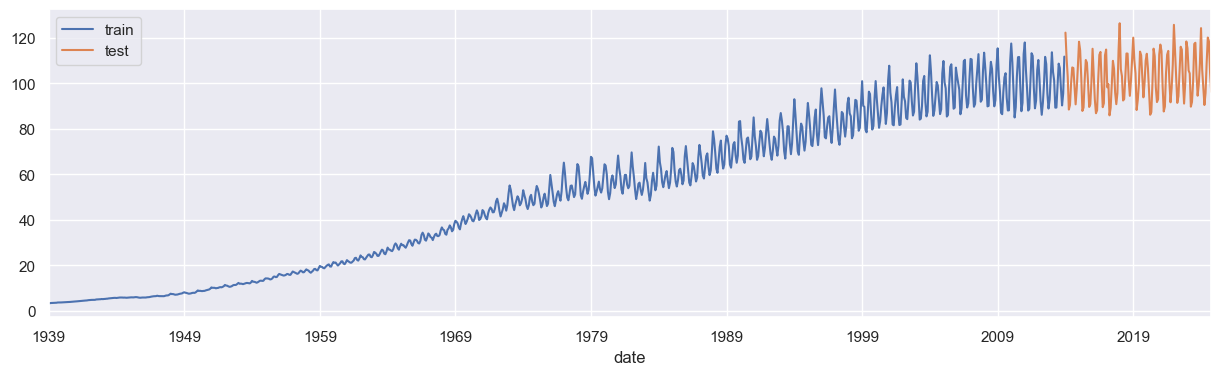

In [24]:
df1 = df['value']

# train test split
# prediction on year 2014 to 2024
df_train = df1[df1.index<'01-01-2014']
df_test = df1[df1.index>='01-01-2014']

def plot_ts(s_train=df_train, s_test=df_test, s_pred=None, ax=None, fit_params=None):
    
    s_train.plot(label='train', ax=ax)
    s_test.plot(label='test', ax=ax)
    if isinstance(s_pred, pd.Series):
        s_pred.plot(label='predict', ax=ax)
    if ax is not None:
        ax.legend(loc='upper right')
        ax.set_title(fit_params)
    else:
        plt.legend()
plot_ts()

In [25]:
prediction = {}
evaluation = {}
# Calculate and return performance metrics
def evaluate(ytrue, ypred):
    scores = {
        'mae': mean_absolute_error(ytrue, ypred),
        'rmse': np.sqrt(mean_squared_error(ytrue, ypred)),
        'r2': r2_score(ytrue, ypred),
        'mape': mean_absolute_percentage_error(ytrue, ypred)
    }
    return scores

In [26]:
#generate one-step forecasts
def ts_one_step_forecast(model, model_abbr, model_params={}, fit_params={}, ax=None):
    ypred = []
    for t in tqdm(range(len(df_test))):
        temp_train = df1[:len(df_train) + t]
        m = model(temp_train, **model_params)
        fit = m.fit(**fit_params)
        predictions = fit.forecast(steps=1)
        ypred.append(predictions)
    
    ypred = pd.concat(ypred)
    prediction[model_abbr] = ypred
    evaluation[model_abbr] = evaluate(df_test, ypred)
    plot_ts(s_pred=ypred, ax=ax, fit_params=fit_params)
    return fit

### Simple exponential smoothing (SES)

100%|██████████| 130/130 [00:02<00:00, 44.71it/s]


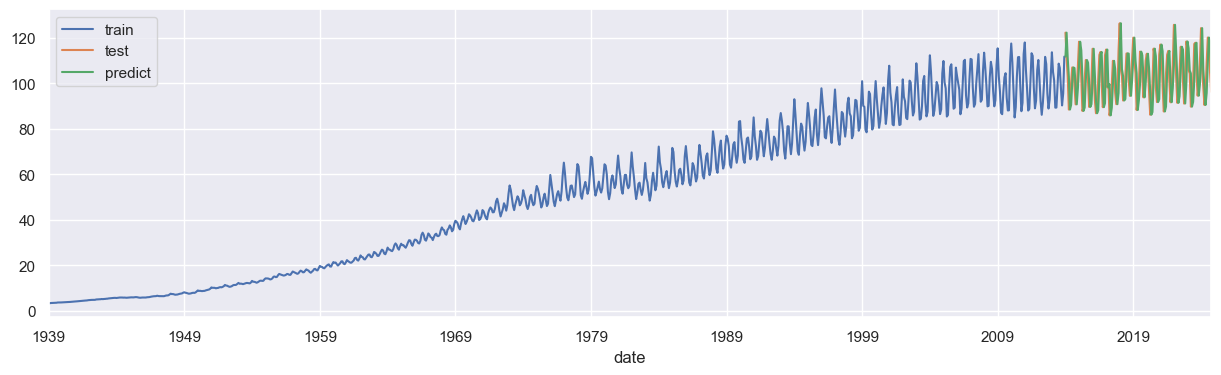

In [27]:
fit_params = {'optimized': True}
fit_ses = ts_one_step_forecast(SimpleExpSmoothing, 'SES', fit_params=fit_params)


### Holt Winter’s Exponential Smoothing (HWES)

100%|██████████| 130/130 [00:28<00:00,  4.53it/s]


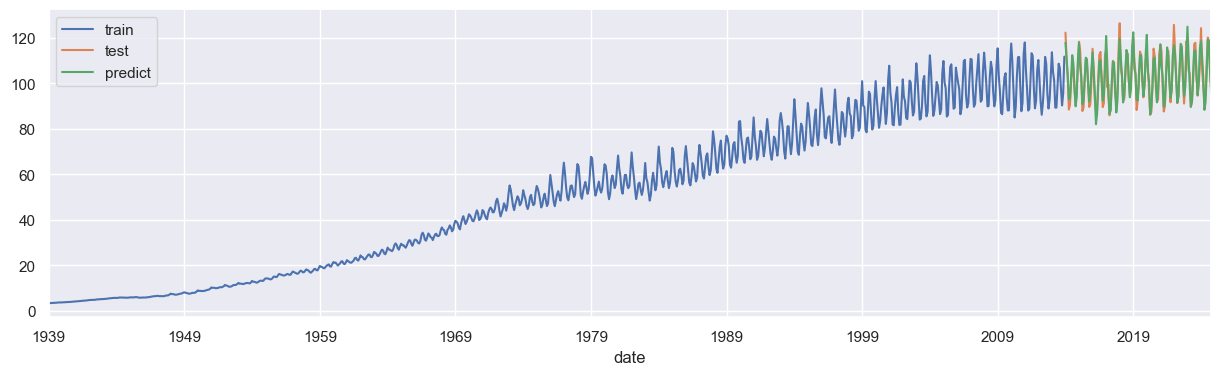

In [28]:
# Adjusting the Exponential Smoothing Model
model_params = {
    'seasonal_periods': 12,
    'trend': 'add',
    'seasonal': 'add',
    'use_boxcox': True,
    'initialization_method': "estimated"
}
fit_params = {'optimized': True}
fit_hwes = ts_one_step_forecast(ExponentialSmoothing, 'HWES', model_params=model_params, fit_params=fit_params)


### ARIMA

100%|██████████| 130/130 [00:28<00:00,  4.53it/s]


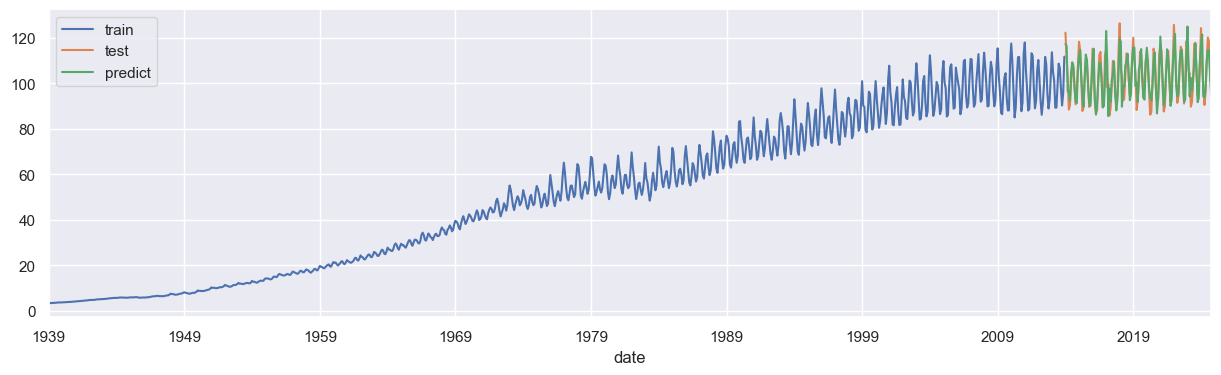

In [29]:
model_params = {'order': (5, 1, 0)}
fit_arima = ts_one_step_forecast(ARIMA, 'ARIMA', model_params=model_params)


### SARIMA

100%|██████████| 130/130 [01:33<00:00,  1.39it/s]


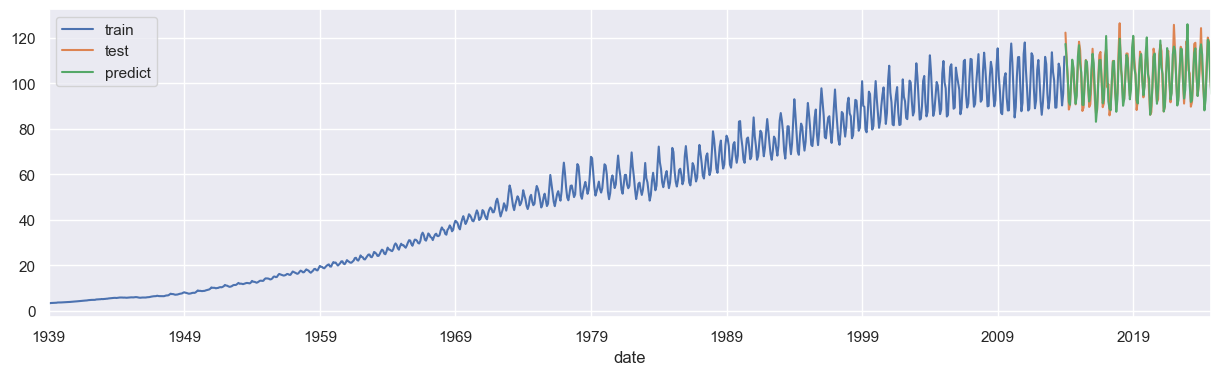

In [30]:
model_params = {'order': (1, 1, 1), 'seasonal_order': (1, 1, 1, 12)}
fit_sarimax = ts_one_step_forecast(SARIMAX, 'SARIMAX', model_params=model_params)


### Prophet

02:07:24 - cmdstanpy - INFO - Chain [1] start processing
02:07:24 - cmdstanpy - INFO - Chain [1] done processing


{'mae': np.float64(2.6398672513897097), 'rmse': np.float64(3.2360018451712467), 'r2': 0.8965297927168108, 'mape': np.float64(0.025503824764610744)}


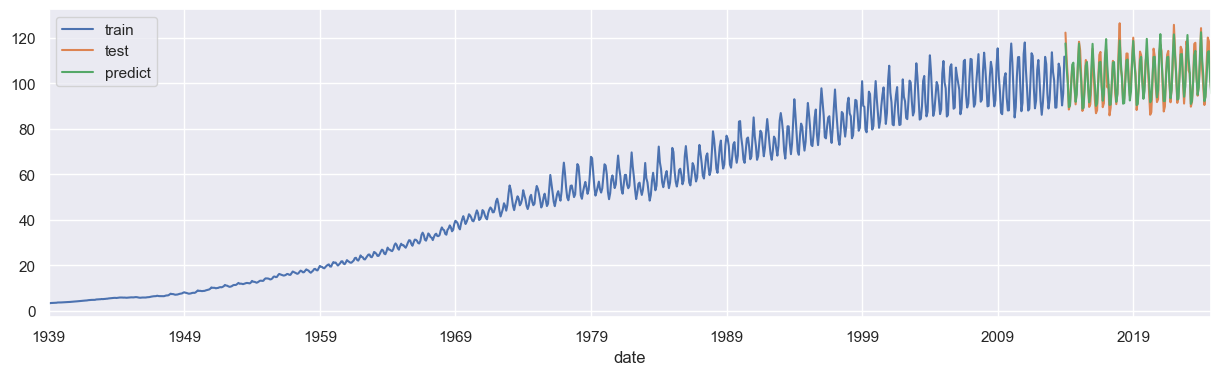

In [31]:
# Prepare data for Prophet
prophet_data = df.reset_index()[['date', 'value']].rename(columns={'date': 'ds', 'value': 'y'}) 
prophet_data['ds'] = pd.to_datetime(prophet_data['ds'])  

# Configure and fit the Prophet model
model_prophet = Prophet(
    yearly_seasonality=True,  
    weekly_seasonality=False,  
    daily_seasonality=False,  
    seasonality_mode='multiplicative'  
)
model_prophet.add_seasonality(name='monthly', period=30.5, fourier_order=10)  
model_prophet.fit(prophet_data)  

# Make forecasts for the test period
future_dates = pd.date_range(start=df_test.index[0], end=df_test.index[-1], freq='M')  
future = pd.DataFrame({'ds': future_dates}) 
forecast = model_prophet.predict(future)  

# Adjust index to match test data
forecast.set_index('ds', inplace=True)  
forecast = forecast.reindex(df_test.index)  

# Save predictions and evaluate
prediction['Prophet'] = forecast['yhat']  
evaluation['Prophet'] = evaluate(df_test, forecast['yhat']) 

# Plot the results
plot_ts(s_pred=forecast['yhat'])  

# Print evaluation results
print(evaluation['Prophet'])


### Transformers (amazon/chronos-t5-tiny)

Chronos is a family of pretrained time series forecasting models based on language model architectures. A time series is transformed into a sequence of tokens via scaling and quantization, and a language model is trained on these tokens using the cross-entropy loss. Once trained, probabilistic forecasts are obtained by sampling multiple future trajectories given the historical context. Chronos models have been trained on a large corpus of publicly available time series data, as well as synthetic data generated using Gaussian processes.


![Chronos architecture](figures_main-figure.png)

In [32]:
!pip install git+https://github.com/amazon-science/chronos-forecasting.git


  Cloning https://github.com/amazon-science/chronos-forecasting.git to c:\users\ahmed\appdata\local\temp\pip-req-build-a3jkhdgn
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit d0c114c81ddc66b75604d24f296ffac65dd42157
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git 'C:\Users\Ahmed\AppData\Local\Temp\pip-req-build-a3jkhdgn'


In [33]:
df2 = df['value']

In [34]:
context = torch.tensor(df2.values)
prediction_length = 12

In [35]:
# Load the pretrained model
pipeline = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-tiny",
  torch_dtype=torch.bfloat16
)
# Make predictions
forecast = pipeline.predict(context, prediction_length)

In [36]:
# Indices for the prediction period
forecast_index = range(len(df2), len(df2) + prediction_length)

# Calculate the quantiles to get an estimate of the prediction interval
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

In [37]:
# Convert the prediction into a time series
forecast_series = pd.Series(median, index=forecast_index)

# Add the Chronos model results to the evaluation
evaluation['Chronos'] = evaluate(df2[-prediction_length:], forecast_series)

## 3. Model Evaluation

In this section, aim to:

- Evaluate the model’s accuracy by applying relevant metrics.
- Examine the model’s results to confirm it captures key aspects of the data.
- Assess the model’s predictive capability, noting any potential limitations.


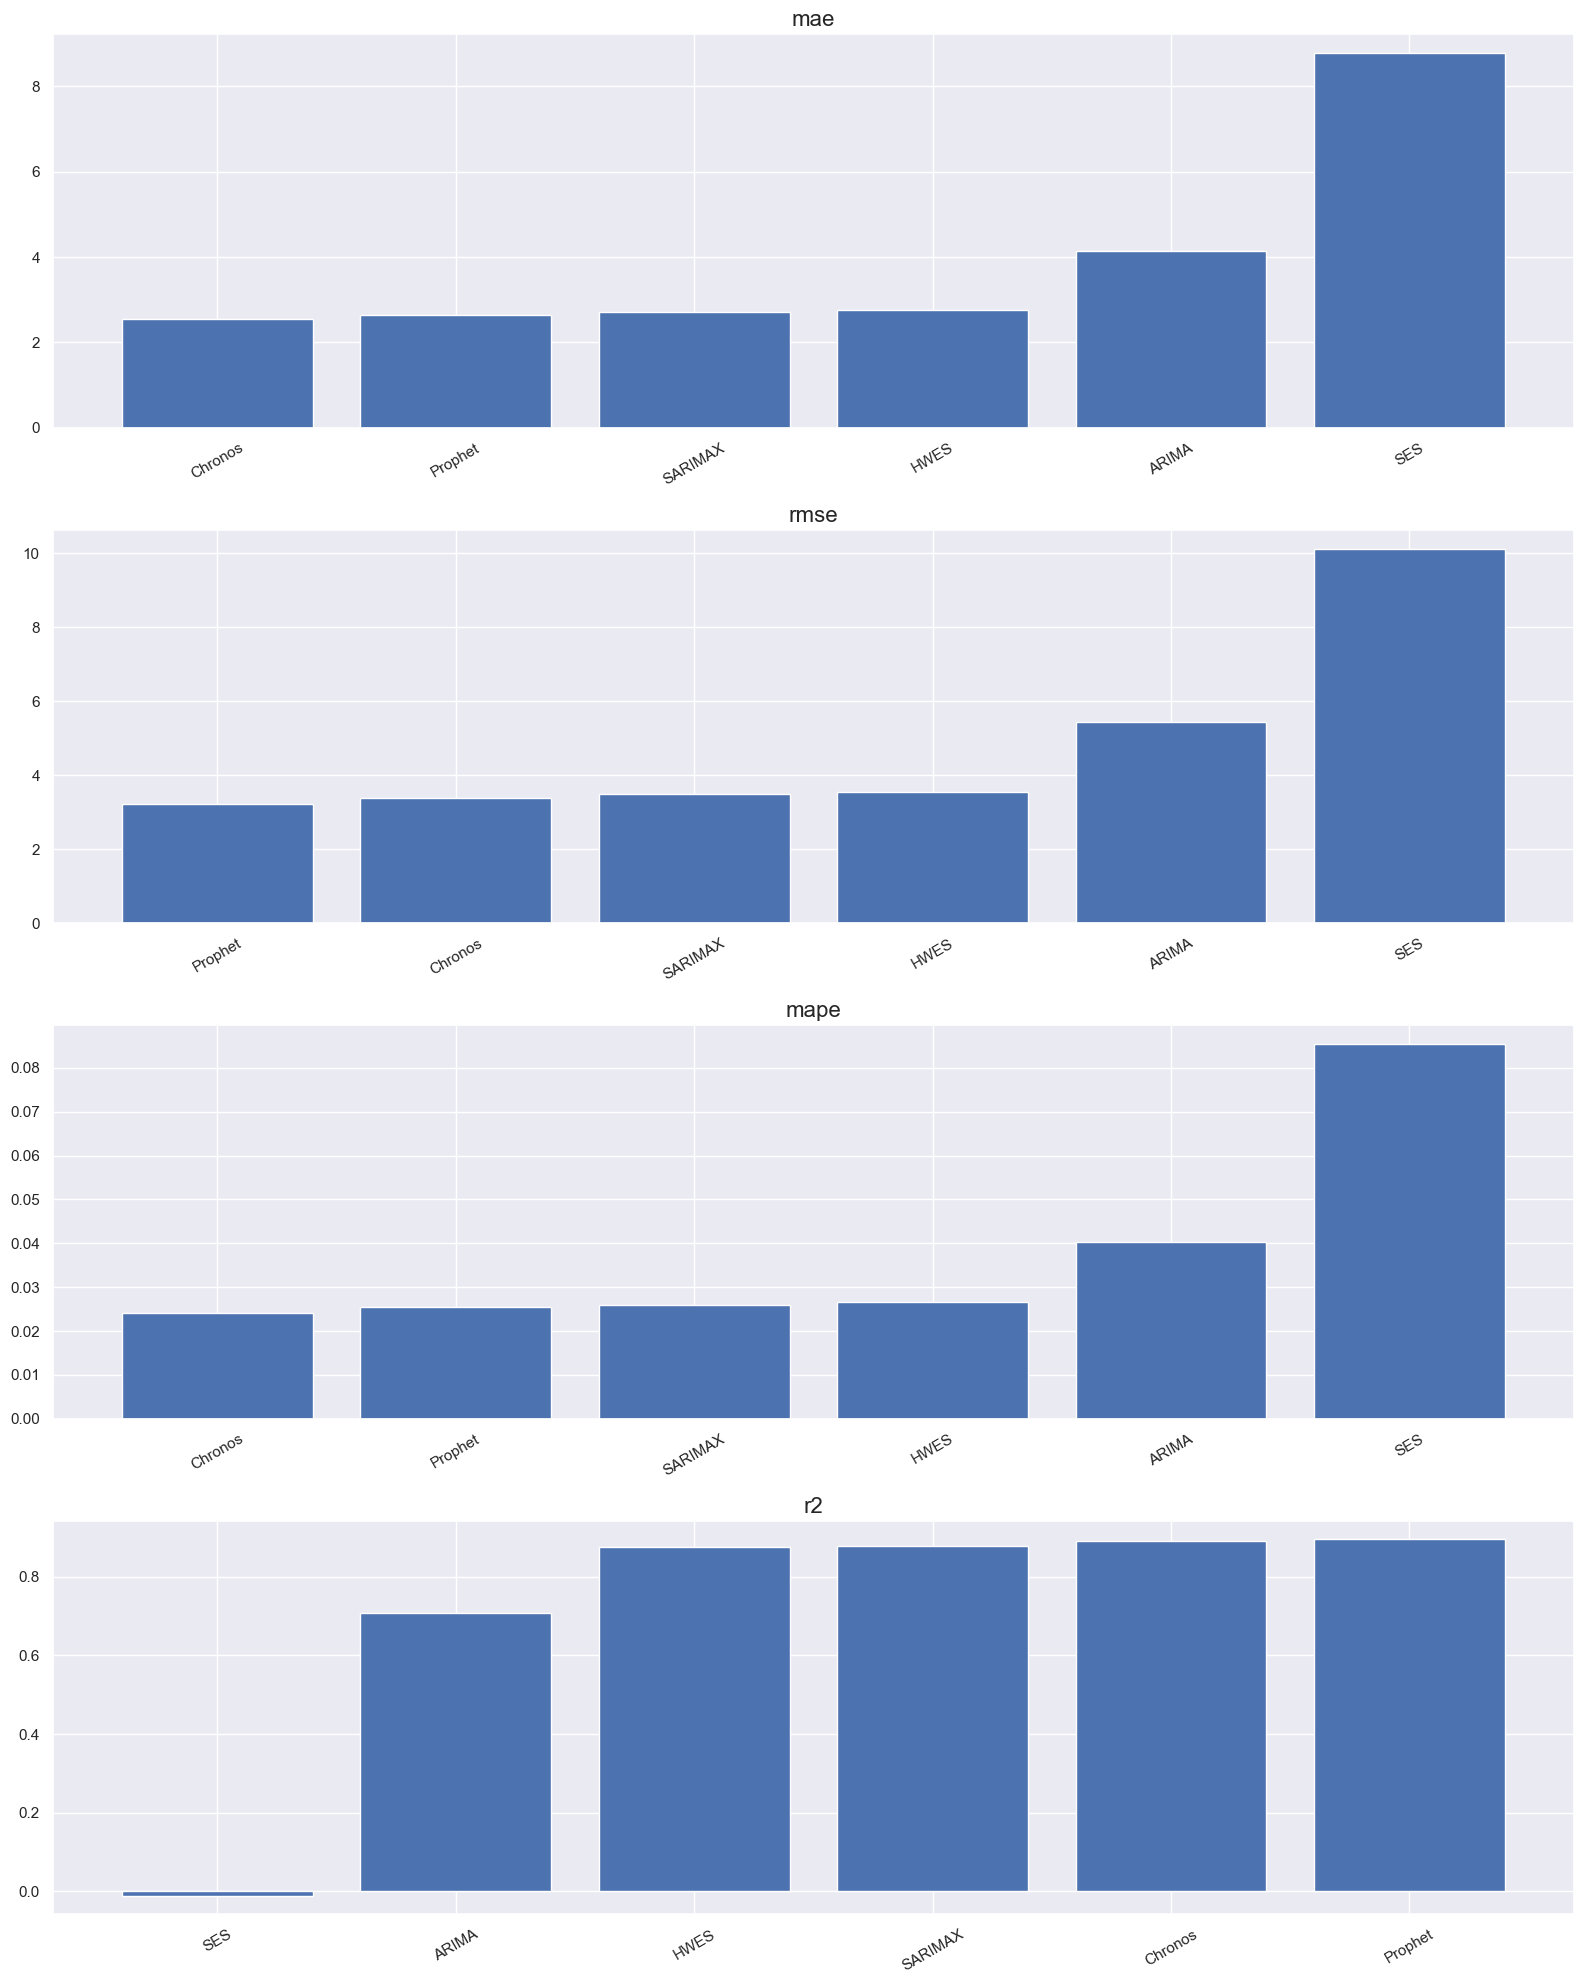

In [38]:
metrics = ['mae', 'rmse', 'mape', 'r2']
fig, axes = plt.subplots(4, 1, figsize=(16, 20))
scores_dict = {}

for i, metric in enumerate(metrics):
    
    # get scores of each metric and sort
    scores_dict[metric] = []
    for k, d in evaluation.items():
        scores_dict[metric].append((k, d[metric]))
    scores_dict[metric] = sorted(scores_dict[metric], key=lambda x:x[1], reverse=False)
    x, y = zip(*scores_dict[metric])
    # plot bar char in descending order of score
    ax = axes[i]
    ax.bar(x, y)
    ax.set_title(metric, fontsize=16)
    ax.set_xticklabels(x, rotation=30)

fig.tight_layout() 
plt.show()

We notice that Chronos is the most performant model.

Thanks for viewing my work